In [1]:
pip install NRCLex


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('punkt')
import spacy
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk
from collections import Counter
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import pipeline
from nrclex import NRCLex
from datetime import datetime
import itertools
import re
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
races_df = pd.read_csv("/content/drive/MyDrive/SI 618 Project Datasets/F1 Race Data/races.csv")
drivers_df = pd.read_csv("/content/drive/MyDrive/SI 618 Project Datasets/F1 Race Data/drivers.csv")
drivers_uni = pd.read_csv("/content/drive/MyDrive/SI 618 Project Datasets/F1 Race Data/drivers.csv")
constructors_df = pd.read_csv("/content/drive/MyDrive/SI 618 Project Datasets/F1 Race Data/constructors.csv")
constructors_standings_df = pd.read_csv("/content/drive/MyDrive/SI 618 Project Datasets/F1 Race Data/constructor_standings.csv")
results_df = pd.read_csv("/content/drive/MyDrive/SI 618 Project Datasets/F1 Race Data/results.csv")
tweets_df = pd.read_csv("/content/drive/MyDrive/SI 618 Project Datasets/F1 Tweets Data/F1_tweets.csv")
tweets_uni = pd.read_csv("/content/drive/MyDrive/SI 618 Project Datasets/F1 Tweets Data/F1_tweets.csv")

## EDA

In [5]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 632388 entries, 0 to 632387
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_name         632382 non-null  object 
 1   user_location     443577 non-null  object 
 2   user_description  592917 non-null  object 
 3   user_created      632388 non-null  object 
 4   user_followers    632388 non-null  float64
 5   user_friends      632388 non-null  object 
 6   user_favourites   632388 non-null  object 
 7   user_verified     632388 non-null  object 
 8   date              632388 non-null  object 
 9   text              632388 non-null  object 
 10  hashtags          632360 non-null  object 
 11  source            632384 non-null  object 
 12  is_retweet        632384 non-null  object 
dtypes: float64(1), object(12)
memory usage: 62.7+ MB


### We can see that our tweets data has 632388 rows with each row representing 1 tweet

In [6]:
devices_df = tweets_df.source.value_counts().sort_values(ascending=False).head(10).reset_index()

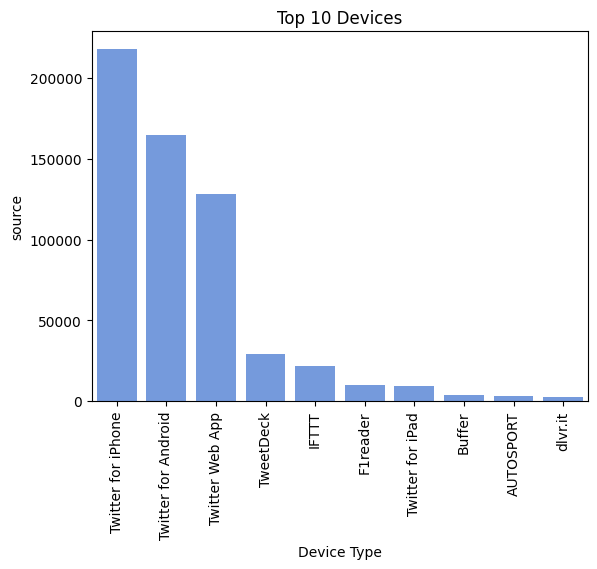

In [7]:
bar_plot = sns.barplot(x='index'
                       ,y='source'
                       ,data=devices_df
                       ,color= 'cornflowerblue')

bar_plot.set(xlabel='Device Type', title='Top 10 Devices')
plt.xticks(rotation=90)
plt.show()

### Inference for the above plot -
We can see that most of our tweets are from iPhones showing just how popular the apple device is amongst the F1 fans.

In [8]:
location_df = tweets_df.user_location.value_counts().sort_values(ascending=False).head(10).reset_index()

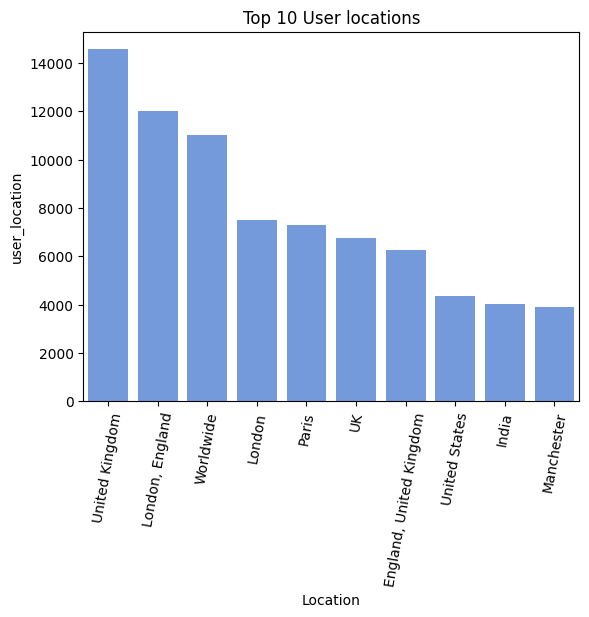

In [9]:
bar_plot = sns.barplot(x='index'
                       ,y='user_location'
                       ,data=location_df
                       ,color= 'cornflowerblue')

bar_plot.set(xlabel='Location', title='Top 10 User locations')
plt.xticks(rotation=80)
plt.show()

The bar graph represents the top 10 user locations from a dataset, likely indicating the geographic distribution of users from a particular platform or within a specific context. The United Kingdom and its capital, London, have the highest counts, implying a significant user base there. Other locations such as Paris, the broader UK, and the United States also feature prominently, suggesting a diverse but predominantly UK-centered user demographic.

In [10]:
tweets_df['date_time'] = pd.to_datetime(tweets_df['date'], errors='coerce')

tweets_df.dropna(subset=['date_time'], inplace=True)

tweets_df['day_of_week'] = tweets_df['date_time'].dt.day_name()

df_temp = tweets_df.groupby('day_of_week')['text'].count().reset_index()

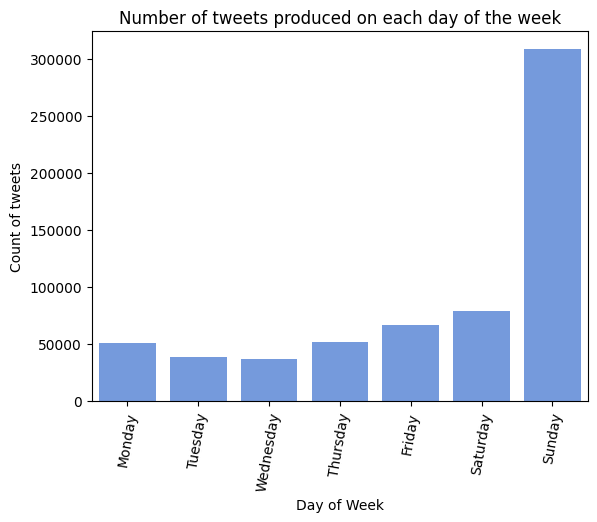

In [11]:
Order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

dx = sns.barplot(df_temp
                ,x='day_of_week'
                ,y='text'
                ,color='cornflowerblue'
                ,order=Order)

dx.set_xticklabels(dx.get_xticklabels()
                   ,rotation=80)

dx.set(xlabel='Day of Week'
       ,ylabel='Count of tweets'
       ,title='Number of tweets produced on each day of the week');

### Inference for the above plot -
The bar graph shows the number of tweets produced on each day of the week. From the graph, it is evident that the number of tweets varies by day, with the least amount of tweeting activity occurring on Monday and the highest on Sunday. There is a gradual increase in the count of tweets from Monday through Sunday, with a noticeable jump between Saturday and Sunday.

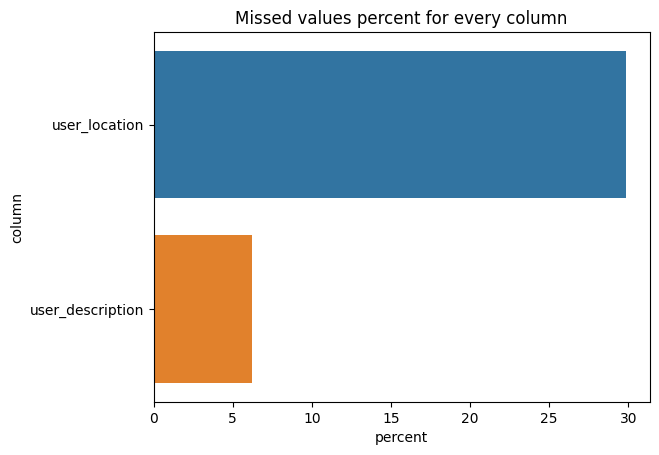

In [12]:
missed = pd.DataFrame()
missed['column'] = tweets_df.columns

missed['percent'] = [round(100* tweets_df[col].isnull().sum() / len(tweets_df), 2) for col in tweets_df.columns]
missed = missed.sort_values('percent',ascending=False)
missed = missed[missed['percent']>0]

fig = sns.barplot(
    x=missed['percent'],
    y=missed["column"],
    orientation='horizontal'
).set_title('Missed values percent for every column')

### Inference for the above plot -

The above plot shows the amount of missing values in the columns 'user_location' and 'user_description'. From the graph, we can see that there are a lot of missing values in user location as most people don't have location turned on for tweets.

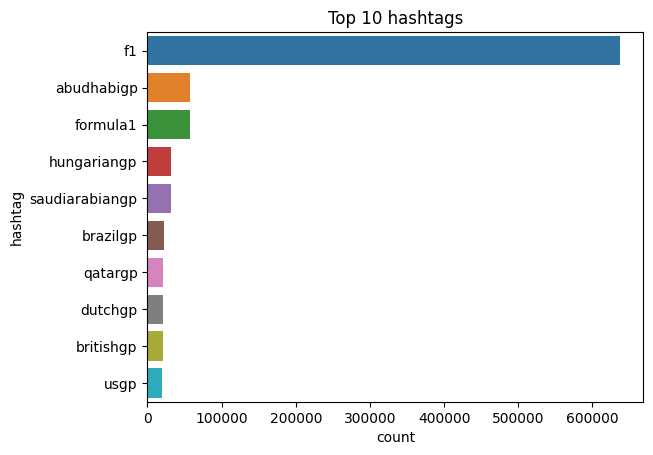

In [13]:
def split_hashtags(x):
    return str(x).replace('[', '').replace(']', '').split(',')

temp_df=tweets_df
temp_df['hashtag'] = temp_df['hashtags'].apply(lambda row : split_hashtags(row))
temp_df = tweets_df.explode('hashtag')
temp_df['hashtag'] = temp_df['hashtag'].astype(str).str.lower().str.replace("'", '').str.replace(" ", '')
temp_df.loc[temp_df['hashtag']=='', 'hashtag'] = 'NO HASHTAG'
#tweets_df

ds = temp_df['hashtag'].value_counts().reset_index()
ds.columns = ['hashtag', 'count']
ds = ds.sort_values(['count'],ascending=False)
fig = sns.barplot(
    x=ds.head(10)["count"],
    y=ds.head(10)['hashtag'],
    orientation='horizontal',
    #title='Top 20 hashtags',
    #width=800,
    #height=700
).set_title('Top 10 hashtags')
#fig.show()

### Inference for the above plot -
The bar lengths indicate the count of tweets associated with each hashtag. The "#f1" hashtag has the highest count, suggesting it is the most commonly used hashtag within this dataset, which could be due to it being the generic hashtag for the sport. The other hashtags have varying counts, likely reflecting the popularity or the level of social media engagement during those specific events.

## Making Combined DF -

In [14]:
races_df['unix_timestamp'] = races_df['date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d")\
                                             .timestamp())

races_df = races_df[races_df['unix_timestamp'].between(1627171200,1660953600)]\
                                              .sort_values(by=['year','round'])

races_df.drop(['url','fp1_date','fp1_time'
               ,'fp2_date','fp2_time','fp3_date'
               ,'fp3_time','quali_time','sprint_time']
              ,axis=1,inplace=True)

results_df.drop(['points','laps','time'
                 ,'milliseconds','fastestLap','rank'
                 ,'fastestLapTime','fastestLapSpeed']
                ,axis=1,inplace=True)

combined_df = pd.merge(races_df
                       ,results_df
                       ,on='raceId'
                       ,how='left')

drivers_df.drop(['number','forename','surname'
                 ,'dob','nationality','url']
                ,axis=1,inplace=True)

constructors_df.drop(['constructorRef','nationality','url']
                     ,axis=1,inplace=True)

combined_df = pd.merge(combined_df
                       ,drivers_df
                       ,on='driverId'
                       ,how='inner')

combined_df = pd.merge(combined_df
                       ,constructors_df
                       ,on='constructorId'
                       ,how='inner')

In [15]:
unique_combinations = combined_df[['code'
                                   ,'driverRef'
                                   ,'name_y']].drop_duplicates()\
                                              .reset_index(drop=True)

In [16]:
unique_combinations

,code,driverRef,name_y
0,OCO,ocon,Alpine F1 Team
1,ALO,alonso,Alpine F1 Team
2,HAM,hamilton,Mercedes
3,RUS,russell,Mercedes
4,BOT,bottas,Mercedes
5,SAI,sainz,Ferrari
6,LEC,leclerc,Ferrari
7,GAS,gasly,AlphaTauri
8,TSU,tsunoda,AlphaTauri
9,LAT,latifi,Williams


The above table shows the driver codes and their names and which team they raced for during the 2021 and 2022 seasons. This also shows how some drivers moved from one team to another from the 2021 to 2022 season

##Q1 - How is Finishing Position of the top 3 F1 drivers related with the sentiment in the tweets for them over each race?

In [17]:
races=combined_df.copy()
tweets=tweets_uni.copy()

In [18]:
code_name_mapping = {
    'HAM' : ['HAM','hamilton','lewis'],
    'VER' : ['VER','max','verstappen'],
    'LEC' : ['LEC','charles','leclerc']
}

In [19]:
# Convert the date string to a pandas datetime object
tweets['date_time'] = pd.to_datetime(tweets['date'], errors='coerce')
# Drop rows where the datetime conversion resulted in NaT
tweets.dropna(subset=['date_time'], inplace=True)

tweets['date']=tweets['date_time'].dt.date
tweets['time']=tweets['date_time'].dt.time
tweets.drop(['user_created'], axis=1, inplace=True)
# Now have to get tweets for each race day.
tweets=tweets[['date', 'text', 'date_time', 'time']]
tweets['time_minute'] = pd.to_datetime(tweets['time'], format='%H:%M:%S').dt.floor('T').dt.time
tweets['time_hour'] = pd.to_datetime(tweets['time'], format='%H:%M:%S').dt.floor('H').dt.time
tweets['yr_mo_dt'] = tweets['date_time'].dt.strftime('%Y-%m-%d')

In [20]:
pivoted_df = races.pivot(index=['raceId','year','round','circuitId','name_x','date','time'], columns=['driverRef'], values='position')

In [21]:
selected_columns = ['max_verstappen', 'hamilton', 'leclerc']
selected_drivers = pivoted_df[selected_columns]
selected_drivers.reset_index(inplace=True)

In [22]:
races_tweets_DF = pd.merge(selected_drivers, tweets, left_on='date', right_on='yr_mo_dt', how='inner')

In [23]:
def check_names(row, code_name):
    names = code_name_mapping.get(code_name, [])
    for name in names:
        if re.search(rf"\b{name}\b"
                    ,row['text']
                    ,re.IGNORECASE):
            return 1
    return 0

In [24]:
for code in code_name_mapping.keys():
  driver_name = code_name_mapping[code][0]  # Assuming there is only one name per code
  races_tweets_DF[driver_name + '_Mentions'] = races_tweets_DF.apply(check_names, axis=1, code_name=driver_name)

In [25]:
# Group by 'RaceId', 'Race', and 'Date' and sum the mentions for each race day
mentions_summary = races_tweets_DF.groupby(['raceId', 'name_x', 'date_x']).agg({
    'HAM_Mentions': 'sum',
    'VER_Mentions': 'sum',
    'LEC_Mentions': 'sum'
}).reset_index()

In [26]:
races_mentions=pd.merge(mentions_summary,selected_drivers, on='raceId', how='left')

Now getting sentiment for every race for the 3 drivers - Max Verstappen, Lewis Hamilton and Charles Leclerc.

In [27]:
races_tweets=races_tweets_DF.copy()

In [28]:
# Dictionary of drivers and their associated keywords
driver_keywords = {
    'max_verstappen': ['max', 'verstappen'],
    'hamilton': ['lewis', 'hamilton'],
    'leclerc': ['charles', 'leclerc']
}

# Initialize a DataFrame to store tagged tweets
tagged_tweets_df = pd.DataFrame(columns=['raceId', 'Driver', 'text'])

# Loop through each driver and each race
for driver, keywords in driver_keywords.items():
    for race_id, race_data in races_tweets_DF[races_tweets_DF['text'].str.contains('|'.join(keywords), case=False)].groupby('raceId'):
        # Extract tweets for the current race and driver
        tweets_for_race = race_data['text']

        # Append the tagged tweets to the DataFrame
        tagged_tweets_df = tagged_tweets_df.append({
            'raceId': race_id,
            'Driver': driver,
            'text': ' '.join(tweets_for_race)
        }, ignore_index=True)

# Function to get sentiment scores using NRCLex
def get_sentiment(text):
    # Create an NRCLex object
    text_object = NRCLex(text)
    # Get the overall sentiment score
    sentiment_score = text_object.raw_emotion_scores
    return sentiment_score

# Initialize a DataFrame to store sentiment scores
sentiment_df = pd.DataFrame(columns=['raceId', 'Driver','Positive', 'Negative', 'Anger', 'Surprise'])

# Loop through each tagged tweet
for _, row in tagged_tweets_df.iterrows():
    # Get sentiment scores using NRCLex
    sentiment_scores = get_sentiment(row['text'])

    # Append the sentiment scores to the DataFrame
    sentiment_df = sentiment_df.append({
        'raceId': row['raceId'],
        'Driver': row['Driver'],
        'Positive': sentiment_scores.get('positive', 0),
        'Negative': sentiment_scores.get('negative', 0),
        'Anger': sentiment_scores.get('anger', 0),
        'Surprise': sentiment_scores.get('surprise', 0),
    }, ignore_index=True)


In [29]:
# List of sentiment columns
sentiment_columns = ['Positive', 'Negative', 'Anger', 'Surprise']

# Function to find the dominant sentiment
def find_dominant_sentiment(row):
    # Calculate the sum of sentiment counts for the row
    total_sentiments = row[sentiment_columns].sum()

    # Find the sentiment column with the highest count
    dominant_sentiment = max(sentiment_columns, key=lambda col: row[col])

    # Calculate the percentage of the dominant sentiment
    dominant_sentiment_percentage = (row[dominant_sentiment] / total_sentiments) * 100

    # Return a tuple containing the dominant sentiment name and percentage
    return dominant_sentiment, dominant_sentiment_percentage

# Apply the function to create two new columns
sentiment_df['Dominant_Sentiment'], sentiment_df['Dominant_Sentiment_Percentage'] = zip(*sentiment_df.apply(find_dominant_sentiment, axis=1))


In [30]:
dominant_senty=sentiment_df.pivot(index=['raceId'],columns=['Driver'],
                                  values=['Dominant_Sentiment_Percentage',
                                          'Dominant_Sentiment']).reset_index()

In [31]:
races_mentions_sentiment=pd.merge(races_mentions,dominant_senty,on='raceId', how='left')
races_mentions_sentiment.reset_index(inplace=True)
races_mentions_sentiment.to_csv('races_mentions_sentiment.csv')

In [32]:
races_mentions_sentiment=pd.read_csv("/content/drive/MyDrive/SI 618 Project Datasets/F1 Tweets Data/races_mentions_sentiment.csv")
races_mentions_sentiment.drop(['Unnamed: 0'],axis=1, inplace=True)

In [33]:
df=races_mentions_sentiment

In [34]:
df['leclerc'].loc[1]=20
df['leclerc']=df['leclerc'].astype('int64')

In [35]:
df['date_x_dt'] = pd.to_datetime(df['date_x'])

# Create a new column by concatenating 'name_x_x' and the year from 'date_x'
df['race_year'] = df.apply(lambda row: f"{row['name_x_x']} {row['date_x_dt'].year}", axis=1)


In [36]:
df=df.sort_values(['date_x_dt'],ascending=True)

In [37]:
#Renaming columns for plot printing
df['Max Verstappen']=df['max_verstappen']
df['Hamilton']=df['hamilton']
df['Charles Leclerc']=df['leclerc']
df["('Dominant_Sentiment_Percentage', 'Max Verstappen')"]=df["('Dominant_Sentiment_Percentage', 'max_verstappen')"]
df["('Dominant_Sentiment', 'Max Verstappen')"]=df["('Dominant_Sentiment', 'max_verstappen')"]

df["('Dominant_Sentiment_Percentage', 'Hamilton')"]=df["('Dominant_Sentiment_Percentage', 'hamilton')"]
df["('Dominant_Sentiment', 'Hamilton')"]=df["('Dominant_Sentiment', 'hamilton')"]

df["('Dominant_Sentiment_Percentage', 'Charles Leclerc')"] = df["('Dominant_Sentiment_Percentage', 'leclerc')"]
df["('Dominant_Sentiment', 'Charles Leclerc')"] = df["('Dominant_Sentiment', 'leclerc')"]

In [38]:
# Extract relevant columns for each driver
max_verstappen_df = df[['raceId', 'race_year', 'date_x', 'name_x_x', 'Max Verstappen',
                        "('Dominant_Sentiment_Percentage', 'Max Verstappen')", "('Dominant_Sentiment', 'Max Verstappen')"]]
hamilton_df = df[['raceId', 'race_year', 'date_x', 'name_x_x', 'Hamilton', "('Dominant_Sentiment_Percentage', 'Hamilton')",
                  "('Dominant_Sentiment', 'Hamilton')"]]
leclerc_df = df[['raceId', 'race_year', 'date_x', 'name_x_x', 'Charles Leclerc', "('Dominant_Sentiment_Percentage', 'Charles Leclerc')",
                 "('Dominant_Sentiment', 'Charles Leclerc')"]]


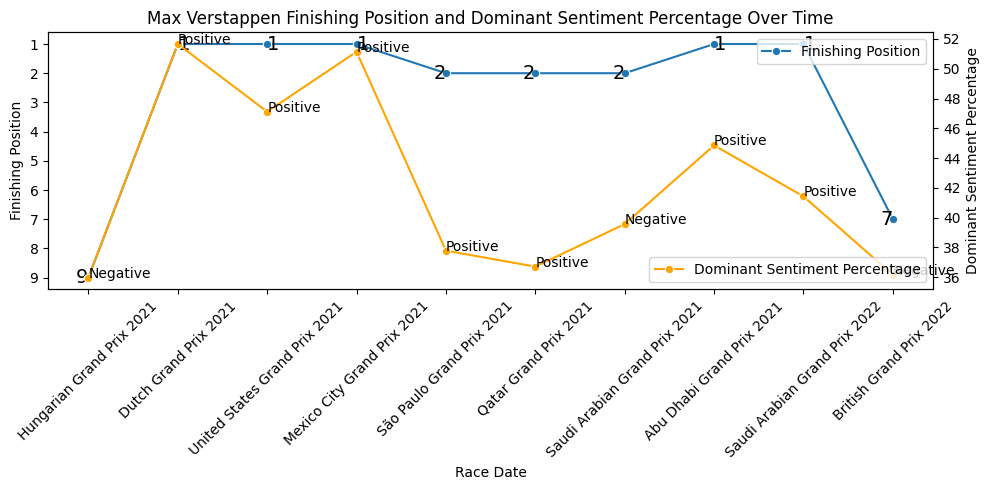

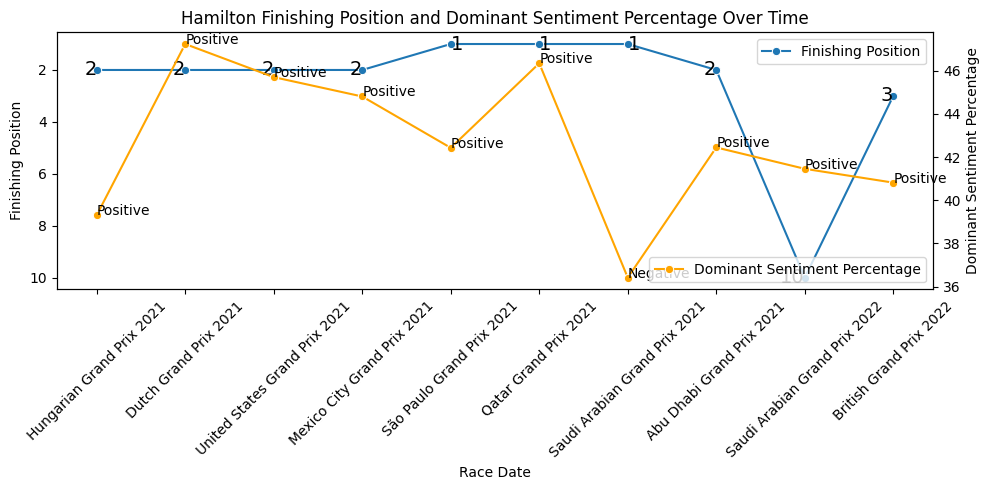

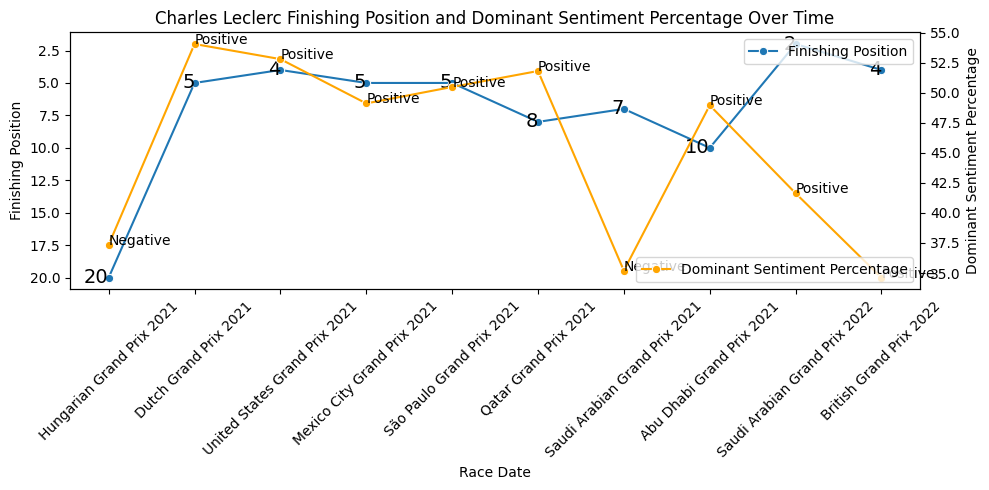

In [39]:
def create_combined_plot(driver_df, driver_name):
    plt.figure(figsize=(10, 5))

    # Plot the finishing position on the left axis
    ax1 = plt.subplot(1, 1, 1)
    sns.lineplot(x='race_year', y=driver_name, data=driver_df, marker='o', ax=ax1, label='Finishing Position')
    ax1.set_ylabel('Finishing Position')
    ax1.set_xlabel('Race Date')
    ax1.invert_yaxis()  # Reverse the y-axis
    ax1.tick_params(axis='x', rotation=45)

    # Label race positions on the plot
    for index, row in driver_df.iterrows():
        ax1.text(row['race_year'], row[driver_name], str(row[driver_name]),
                 ha='right' if row[driver_name] > 1 else 'left',
                 va='center', color='black', fontsize=14)

    # Create a secondary axis for dominant sentiment percentage on the right
    ax2 = ax1.twinx()
    sns.lineplot(x='race_year', y=f"('Dominant_Sentiment_Percentage', '{driver_name}')",
                 data=driver_df, marker='o', ax=ax2, color='orange',
    label='Dominant Sentiment Percentage')
    ax2.set_ylabel('Dominant Sentiment Percentage')

    for index, row in driver_df.iterrows():
        ax2.text(row['race_year'], row[f"('Dominant_Sentiment_Percentage', '{driver_name}')"], str(row[f"('Dominant_Sentiment', '{driver_name}')"]))

    # Add legend
    ax1.legend(loc='upper right')
    ax2.legend(loc='lower right')

    plt.title(f'{driver_name} Finishing Position and Dominant Sentiment Percentage Over Time')
    plt.tight_layout()
    plt.show()


# Create combined plots for each driver
create_combined_plot(max_verstappen_df, 'Max Verstappen')
create_combined_plot(hamilton_df, 'Hamilton')
create_combined_plot(leclerc_df, 'Charles Leclerc')

Inference from the above plot for driver's Race Positions vs Tweet Sentiments:

1. For the race of Saudi Arabian'21 : All the three players, Max, Hamilton and Leclerc have negative sentiments showing in the tweets
due to the eccentric nature of this race. From the start of the race, Max and Hamilton were having a brutal fight with each other.

2. Shortly into the race, Max made an overtake on Hamilton by going off the track. So he overtook but was condemned by everyone. He was later given a penalty for this.
Later in lap 37, Max Verstappen made an illegal overtake on Hamilton, for which he was asked to let Hamilton pass by.

3. Max decided to allow Hamilton to pass just before the DRS point and also Hamilton wasn't informed of this and hence when Max slowed down, Hamilton could not
avoid bumping into Verstappen when he slowed down, leading to a small collision between the two. Hamilton post-race criticized Max for this.

4. So this race from the start to the end, saw a lot of tussle between Hamilton and Max and hence led to a lot of heated tweets by their fans or critiques,
Keeping the overall sentiment of the race day negative for both the drivers.

5. Charles Leclerc was involved in an incident shortly into the race and despite starting 4th on the grid, could only finish 7th in a Ferrai.
That was nothing short of a disappointment for Ferrari Fans and hence his sentiment in the tweets also stayed negative.

## Question 2 - Does most position gained in a race leads to higher trend in tweets on a race day compared to all other race days ?

In [40]:
# Find Driver who gained most positions in each race (Initial position - Final Position)
pos_gained_DF = combined_df[combined_df['position'] != '\\N']
pos_gained_DF['grid'] = pos_gained_DF['grid'].apply(lambda x: 20 if x==0 else x)
pos_gained_DF['position'] = pos_gained_DF['position'].astype('int')
pos_gained_DF['pos_gained'] = pos_gained_DF['grid'] - pos_gained_DF['position']
idx = pos_gained_DF.groupby(['year','round'])['pos_gained'].idxmax()
mx_gain_DF = pos_gained_DF.loc[idx]
mx_gain_DF.drop(columns=['raceId','time','quali_date'
                         ,'sprint_date','unix_timestamp','resultId'
                         ,'driverId','constructorId','positionText'
                         ,'positionOrder','statusId']
                ,inplace=True)

In [41]:
# Getting alias for drivers
code_name_mapping = {
    'HAM' : ['HAM','hamilton','lewis'],
    'BOT' : ['BOT','bottas','valtteri'],
    'SAI' : ['SAI','sainz','carlos'],
    'RAI' : ['RAI','raikkonen','kimi'],
    'PER' : ['PER','perez','sergio','checo'],
    'VER' : ['VER','max','verstappen'],
    'VET' : ['VET','vettel','seb','sebastian'],
    'NOR' : ['NOR','norris','lando'],
    'GAS' : ['GAS','gasly','pierre'],
    'TSU' : ['TSU','yuki','tsunoda'],
    'ALB' : ['ALB','albon','alex'],
    'RUS' : ['RUS','russell','george'],
    'OCO' : ['OCO','ocon','esteban'],
    'ALO' : ['ALO','alonso','fernando'],
    'MSC' : ['MSC','mick','schumacher'],
    'LEC' : ['LEC','charles','leclerc']
}

In [42]:
tweets_df['yr_mo_dt'] = tweets_df['date_time'].dt.strftime('%Y-%m-%d')

In [43]:
tweets_df.drop(columns=['date','date_time'],inplace=True)

In [44]:
#get race-day tweets
race_day_tweets_DF = pd.merge(mx_gain_DF
                              ,tweets_df
                              ,left_on = 'date'
                              ,right_on = 'yr_mo_dt'
                              ,how = 'inner')

In [45]:
#Function to check if driver alias mentioned in tweet or not (Should be common for other quesions)
def check_names(row):
    code = row['code']
    names = code_name_mapping.get(code, [])
    for name in names:
        if re.search(rf"\b{name}\b"
                     ,row['text']
                     ,re.IGNORECASE):
            return 1
    return 0

In [46]:
#Keep tweets where driver who gained most positions was mentioned
race_day_tweets_DF['driver_mentions'] = race_day_tweets_DF.apply(check_names
                                                                 ,axis=1)

In [47]:
#Total tweets for each race
tot_tweets_DF = race_day_tweets_DF.groupby(['year','round'])['text']\
                                  .count()\
                                  .reset_index()

In [48]:
#DF which contains the number of tweets driver got for each race he gained most pos in
tweet_count_gain_DF = race_day_tweets_DF.groupby(['year'
                                                  ,'round'
                                                  ,'code'])['driver_mentions']\
                                        .sum()\
                                        .reset_index()

In [49]:
# Join with total tweets and get percentage mentions
count_combined_DF = pd.merge(tweet_count_gain_DF
                             ,tot_tweets_DF
                             ,on=['year','round']
                             ,how='inner')

count_combined_DF['percetage_mentions'] = (count_combined_DF['driver_mentions']/count_combined_DF['text'])*100

In [50]:
# Get mean driver mentions when gained most pos
tweet_count_gain__mean_DF = count_combined_DF.groupby('code')['percetage_mentions']\
                                               .mean()\
                                               .reset_index()

In [51]:
# Get unique ids from above data
unique_ids = tweet_count_gain_DF['code'].unique()

In [52]:
# FInd number of mentions for each driver in each race
def check_id(text,id):
    names = code_name_mapping.get(id, [])
    for name in names:
        if re.search(rf"\b{name}\b"
                     ,text
                     ,re.IGNORECASE):
            return 1
    return 0

In [53]:
# Get mean % mentions for each driver
for unique_id in unique_ids:
    race_day_tweets_DF[unique_id] = 0

for unique_id in unique_ids:
    race_day_tweets_DF[unique_id] = race_day_tweets_DF['text'].apply(lambda x: check_id(x, unique_id))

tweets_num_DF = race_day_tweets_DF.groupby(['year'
                                            ,'round'])[unique_ids]\
                                  .sum()\
                                  .reset_index()

count_combined_DF = pd.merge(tweets_num_DF
                             ,tot_tweets_DF
                             ,on=['year','round']
                             ,how='inner')

divider_column = 'text'

columns_to_update = unique_ids

count_combined_DF[unique_ids] = count_combined_DF[unique_ids].div(count_combined_DF[divider_column], axis=0)*100

mean_values = count_combined_DF.drop(columns=['year'
                                              ,'round'
                                              ,'text'])\
                               .mean()

result_df = pd.DataFrame({
    'Driver': mean_values.index,
    'Avg_tweets': mean_values.values,
})

In [54]:
#Prepare final_table to be plotted
final_table = pd.merge(result_df
                       ,tweet_count_gain__mean_DF
                       ,left_on = 'Driver'
                       ,right_on = 'code'
                       ,how='inner').drop(columns=['code'])

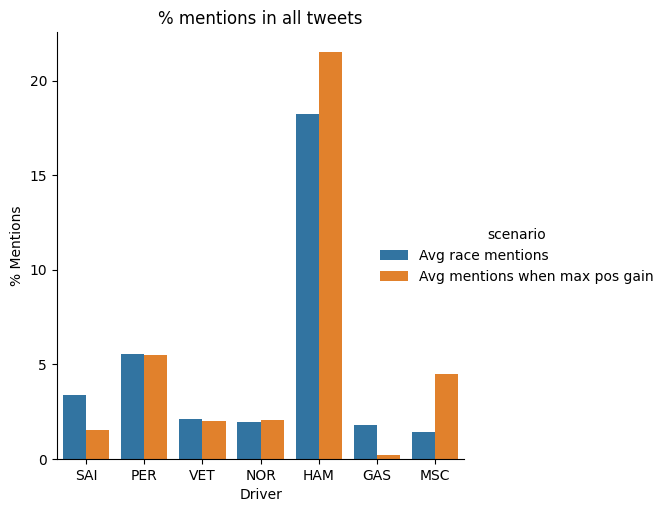

In [55]:
dfs1 = pd.melt(final_table, id_vars = "Driver")
dfs1 = dfs1.rename(columns={"variable": "scenario"})

plot=sns.catplot(x = 'Driver', y ='value'
                 ,hue = 'scenario',data = dfs1
                 ,kind ='bar')

plt.xlabel("Driver")
plt.ylabel("% Mentions")
plt.title("% mentions in all tweets")

new_legend_labels = ["Avg race mentions"
                     ,"Avg mentions when max pos gain"]

for t, l in zip(plot._legend.texts, new_legend_labels):
    t.set_text(l)

plt.show()

## Inference -
We can see that for the majority of drivers there is no significant difference in the amount of mentions a driver gets on an average race day vs the races where he gains the most positions. This could be due to the fact that F1 usually does not highlight the driver gaining most positions in a race unless they come from way back in the field to the front. We do have 2 drivers though in Hamilton and Schumacher who are showing an increase in mentions though, let us understand why for each:
- Lewis Hamilton (HAM) : There are 2 races in our dataset where Hamilton gained the most positions, the 2021 Brazil Grand Prix and the 2022 Saudi Grand Prix. In the 2021 Brazil Grand Prix, Hamilton famously started from last position and still managed to win the race. This amazing performance meant that he received an overwhelming amount of mentions on twitter, pushing his average higher.
- Mick Schumacher (MSC) : In the 2022 British Grand Prix, Schumacher gained the most positions in the race but his increase in trend is most likely due to the fact that it was his first point scoring finish in F1 for which he received increased attention.

We also have Pierre Gasly (GAS) who actually received less % of mentions in the race where he gained the most positions. This is because Gasly gained the most positions in the 2021 Abu Dhabi Grand Prix where all attention was on Hamilton VS Verstappen. Thus there was actually a decrease in the % of mentions he usually gets.


## Question 3 - What is the emotion towards mid-order drivers for 2021 season ?

In [56]:
# Get all 2021 races
races_2021_DF = races_df[races_df['year']==2021]

In [59]:
# Sum up constructor points and find mid-tabble teams
constructor_races_DF = pd.merge(races_2021_DF
                                ,constructors_standings_df
                                ,on='raceId'
                                ,how='inner')

constructor_2021_standing_DF = constructor_races_DF.groupby('constructorId')['points']\
                                                   .sum()\
                                                   .reset_index(name='points_scored')\
                                                   .sort_values(by='points_scored', ascending=False)\
                                                   .reset_index(drop=True)

midtable_2021_DF = constructor_2021_standing_DF.iloc[3:7]\
                                               .reset_index(drop=True)

drivers_df = drivers_uni.copy()

In [60]:
# Use results table to get which drivers were part of the mid-table teams in 2021 and get a list of all their aliases
drivers_constructors_Df = pd.merge(races_2021_DF,results_df,on='raceId',how='inner')

drivers_constructors_Df = drivers_constructors_Df[['driverId'
                                                   ,'constructorId']].drop_duplicates()\
                                                                     .reset_index(drop=True)

MidTable_Drivers_Df = pd.merge(midtable_2021_DF
                               ,drivers_constructors_Df
                               ,on='constructorId'
                               ,how='inner')

MidTable_Drivers_Df = pd.merge(MidTable_Drivers_Df
                               ,drivers_df
                               ,on='driverId'
                               ,how='inner')

selected_columns = ['code'
                    ,'forename'
                    ,'surname']
driver_list = MidTable_Drivers_Df[selected_columns].values\
                                                   .flatten()\
                                                   .tolist()

In [61]:
def check_names(row):
    for name in driver_list:
        if re.search(rf"\b{name}\b"
                     ,row['text']
                     ,re.IGNORECASE):
            return 1
    return 0

### Preprocessing the tweets for a better analysis -
* URL Removal: Removes any web links.
* Mention Removal: Takes out '@' mentions.
* Hashtag Removal: Clears '#' symbols (but keeps the text of the hashtag, which might be relevant).
* Punctuation Removal: Strips punctuation which typically doesn't contribute to sentiment.
* Lowercasing: Converts all characters to lowercase for consistency.
* Number Removal: Takes out numbers.
* Extra Space Removal: Gets rid of extra whitespace, leading, and trailing spaces.

In [62]:
# Function to clean tweets
def clean_tweet(tweet):
    # Remove URLs
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet
    tweet = re.sub(r'\@\w+|\#', '', tweet)
    # Remove punctuations
    tweet = re.sub(r'[^\w\s]', '', tweet)
    # Convert text to lowercase
    tweet = tweet.lower()
    # Remove numbers
    tweet = re.sub(r'\d+', '', tweet)
    # Remove extra spaces
    tweet = re.sub(r'\s+', ' ', tweet).strip()
    return tweet

In [63]:
#Take only 2021 tweets
#Get all tweets where the mid-table drivers are mentioned
#Clean the tweets
tweets_df['year'] = tweets_df['yr_mo_dt'].str[:4]

filtered_df = tweets_df[tweets_df['year'] == '2021']

filtered_df['mid_table_mention'] = filtered_df.apply(check_names, axis=1)

filtered_df = filtered_df[filtered_df['mid_table_mention']==1]


In [64]:
filtered_df['yr_mo_dt'] = filtered_df['yr_mo_dt'].str[:10]

filtered_df = filtered_df.reset_index(drop=True)

filtered_df['cleaned_text'] = filtered_df['text'].apply(clean_tweet)

In [65]:
def analyze_emotions(text):
    emotion_scores = NRCLex(text).affect_frequencies
    return emotion_scores

In [66]:
#Perform emotion analysis using NRCLex
filtered_df['NRClex_emotions'] = filtered_df['cleaned_text'].apply(analyze_emotions)

sentiment_df = pd.DataFrame(list(filtered_df['NRClex_emotions']))
sentiment_df = sentiment_df.fillna(0)

filtered_df['date_time'] = pd.to_datetime(filtered_df['yr_mo_dt'])

result_df = pd.concat([filtered_df.date_time, sentiment_df], axis=1)

In [67]:
#Prepare data to be plotted
plotting_data_DF = result_df.groupby('date_time')\
                            .sum()\
                            .reset_index()\
                            .sort_values(by='date_time')

In [68]:
fig = px.line(plotting_data_DF
              ,x='date_time'
              ,y=['fear','anger','surprise'
                  ,'positive','negative','sadness'
                  ,'disgust','joy'],
              labels={'value': 'Aggreagte emotion scores'},
              title='Mid-table drivers emotion over the year')

fig.update_xaxes(title_text='Dates')

vertical_line_dates = [['2021-08-01','Hungarian Grand Prix',100,.75]
                      ,['2021-09-05','Dutch Grand Prix',-300,.55]
                      ,['2021-10-24','US Grand Prix',-1200,.25]
                      ,['2021-11-07','Mexico Grand Prix',-550,.45]
                      ,['2021-11-14','Brazil Grand Prix',300,.75]
                      ,['2021-11-21','Qatar Grand Prix',-1000,.30]
                      ,['2021-12-05','Saudi Grand Prix',-300,.60]
                      ,['2021-12-12','Abu Dhabi Grand Prix',100,.65]]
for date,grand_prix,adjust,y1 in vertical_line_dates:
    fig.add_shape(
        dict(
            type="line",
            x0=date,
            x1=date,
            y0=0,
            y1=y1,
            yref="paper",
            line=dict(color="red", width=1,dash='dash')
        )
    )
    fig.add_annotation(
        dict(
            x=date,
            y=1800+adjust,  # Adjust the y-coordinate for annotation placement
            text=grand_prix,
            showarrow=True,
            arrowhead=5,
            ax=0,
            ay=-40)
        )

fig.show()

## Inference -
We can see that over the entire 2021 season the dominant emotion was always that of positive towards the mid-order drivers. One way to understand this would be that as these are mid-order drivers, the spikes in emotion scores typically happen when they do something significant to affect the race results. Like in the 2021 Hungarian Grand Prix, where Esteban Ocon (Alpine) won from Hamilton and Fernando Alonso (Alpine) managed to hold Hamilton behind him for a long time and then in the 2021 Qatar Grand Prix, where Alonso finished third.

Apart from these over an average race day, as they get very low screen time and usually are not part of any significant narrative, most tweets would just be from the fans of each driver and thus it is understandable that they are majorly positive towards their favorite driver.

After positive we can see that the other major emotions are that of negative, surprise, joy and fear. This shows that people are usually surprised or in joy when these mid-order drivers become part of some race changing event and they also get negative tweets most probably from the fans of the leading drivers whose race results get affected from such events.

##Question 4 - Is there a direct correlation between twitter sentiments of a Formula 1 team's qualifying position vs final position on race days ?

In [69]:
tweets = tweets_uni.copy()
races_tweets_merged = races_tweets_DF.copy()
races_data_merged = combined_df.copy()

In [70]:
tweets=tweets[['date', 'text']]
# Convert the date string to a pandas datetime object
tweets['date_time'] = pd.to_datetime(tweets['date'], errors='coerce')

# Drop rows where the datetime conversion resulted in NaT
tweets.dropna(subset=['date_time'], inplace=True)

tweets['date']=tweets['date_time'].dt.date
tweets['time']=tweets['date_time'].dt.time
# tweets.drop(['user_created'], axis=1, inplace=True)
tweets.rename(columns={'date': 'datetime'}, inplace=True)
tweets['yr_mo_dt']=tweets['date_time'].dt.strftime('%Y-%m-%d')

In [71]:
pivoted_df = races_data_merged.pivot(index=['raceId','year','round','circuitId','name_x','date','quali_date','time'], columns=['driverRef'], values='position')

In [72]:
pivoted_df.reset_index()

driverRef,raceId,year,round,circuitId,name_x,date,quali_date,time,albon,alonso,...,ocon,perez,raikkonen,ricciardo,russell,sainz,stroll,tsunoda,vettel,zhou
0,1051,2021,20,78,Qatar Grand Prix,2021-11-21,2021-11-20,14:00:00,NaN,3,...,5,4,14,12,17,7,6,13,10,NaN
1,1062,2021,11,11,Hungarian Grand Prix,2021-08-01,2021-07-31,13:00:00,NaN,4,...,1,\N,10,11,8,3,\N,6,\N,NaN
2,1063,2021,12,13,Belgian Grand Prix,2021-08-29,2021-08-28,13:00:00,NaN,11,...,7,19,18,4,2,10,20,15,5,NaN
3,1064,2021,13,39,Dutch Grand Prix,2021-09-05,2021-09-04,13:00:00,NaN,6,...,9,8,NaN,11,17,7,12,\N,13,NaN
4,1065,2021,14,14,Italian Grand Prix,2021-09-12,2021-09-10,13:00:00,NaN,8,...,10,5,NaN,1,9,6,7,\N,12,NaN
5,1066,2021,15,71,Russian Grand Prix,2021-09-26,2021-09-25,12:00:00,NaN,6,...,14,9,8,4,10,3,11,17,12,NaN
6,1067,2021,16,5,Turkish Grand Prix,2021-10-10,2021-10-09,12:00:00,NaN,16,...,10,3,12,13,15,8,9,14,18,NaN
7,1069,2021,17,69,United States Grand Prix,2021-10-24,2021-10-23,19:00:00,NaN,\N,...,\N,3,13,5,14,7,12,9,10,NaN
8,1070,2021,18,32,Mexico City Grand Prix,2021-11-07,2021-11-06,19:00:00,NaN,9,...,13,3,8,12,16,6,14,\N,7,NaN
9,1071,2021,19,18,São Paulo Grand Prix,2021-11-14,2021-11-12,17:00:00,NaN,9,...,8,4,12,\N,13,6,\N,15,11,NaN


In [73]:
selected_columns = ['latifi', 'russell', 'max_verstappen', 'perez']
selected_drivers = pivoted_df[selected_columns]
selected_drivers.reset_index()

driverRef,raceId,year,round,circuitId,name_x,date,quali_date,time,latifi,russell,max_verstappen,perez
0,1051,2021,20,78,Qatar Grand Prix,2021-11-21,2021-11-20,14:00:00,\N,17,2,4
1,1062,2021,11,11,Hungarian Grand Prix,2021-08-01,2021-07-31,13:00:00,7,8,9,\N
2,1063,2021,12,13,Belgian Grand Prix,2021-08-29,2021-08-28,13:00:00,9,2,1,19
3,1064,2021,13,39,Dutch Grand Prix,2021-09-05,2021-09-04,13:00:00,16,17,1,8
4,1065,2021,14,14,Italian Grand Prix,2021-09-12,2021-09-10,13:00:00,11,9,\N,5
5,1066,2021,15,71,Russian Grand Prix,2021-09-26,2021-09-25,12:00:00,19,10,2,9
6,1067,2021,16,5,Turkish Grand Prix,2021-10-10,2021-10-09,12:00:00,17,15,2,3
7,1069,2021,17,69,United States Grand Prix,2021-10-24,2021-10-23,19:00:00,15,14,1,3
8,1070,2021,18,32,Mexico City Grand Prix,2021-11-07,2021-11-06,19:00:00,17,16,1,3
9,1071,2021,19,18,São Paulo Grand Prix,2021-11-14,2021-11-12,17:00:00,16,13,2,4


In [74]:
quali_data_merged = pd.merge(selected_drivers, tweets, left_on='quali_date', right_on='yr_mo_dt', how='inner')

In [75]:
# Filter tweets between 01-01-2021 and 12-31-2021
quali_data_merged['yr_mo_dt'] = pd.to_datetime(quali_data_merged['yr_mo_dt'], errors='coerce')
quali_tweets_2021= quali_data_merged[(quali_data_merged['yr_mo_dt'] >= '2021-01-01') & (quali_data_merged['yr_mo_dt'] <= '2021-12-31')]

In [76]:
# Clean the tweets
quali_tweets_2021['clean_tweet'] = quali_tweets_2021['text'].apply(clean_tweet)

In [77]:
# Define keywords related to the Saudi GP missile attack
keywords_redbull = ["verstappen","redbull","perez", "max", "sergio", "checo"]
keywords_williams = ["russell","latifi","williams","nicholas","george"]
# Filter tweets containing any of the keywords
pattern_redbull = '|'.join(keywords_redbull)
pattern_williams = '|'.join(keywords_williams)
df_filtered_redbull= quali_tweets_2021[quali_tweets_2021['clean_tweet'].str.contains(pattern_redbull, case=False, na=False)]
df_filtered_williams= quali_tweets_2021[quali_tweets_2021['clean_tweet'].str.contains(pattern_williams, case=False, na=False)]

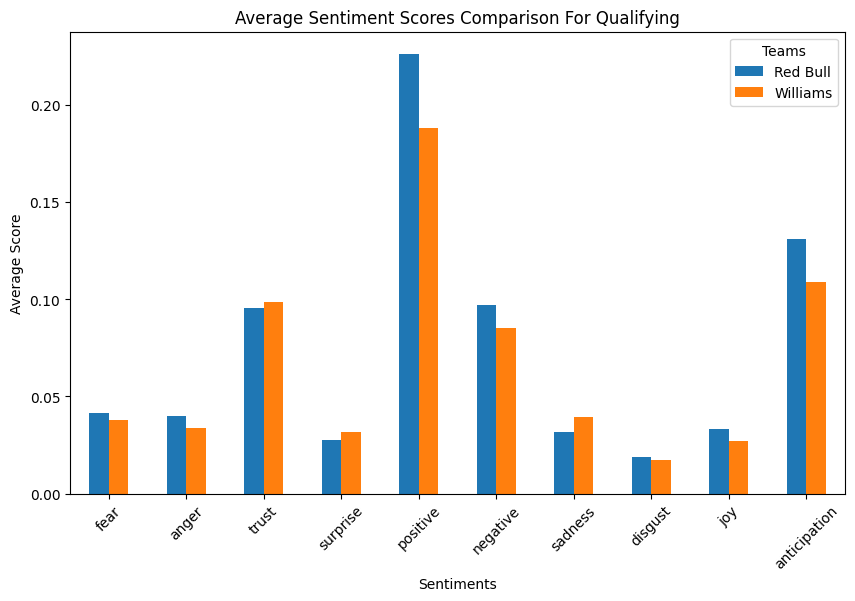

In [78]:
# Function to perform sentiment analysis
def analyze_sentiment(text):
    emotion = NRCLex(text)
    return emotion.affect_frequencies

# Apply sentiment analysis to each tweet
df_filtered_redbull['sentiment'] = df_filtered_redbull['clean_tweet'].apply(analyze_sentiment)
df_filtered_williams['sentiment'] = df_filtered_williams['clean_tweet'].apply(analyze_sentiment)

# Prepare data for plotting
sentiment_df_redbull = pd.DataFrame(list(df_filtered_redbull['sentiment']))
sentiment_df_redbull = sentiment_df_redbull.fillna(0)  # Replace NaNs with zeros

sentiment_df_williams = pd.DataFrame(list(df_filtered_williams['sentiment']))
sentiment_df_williams = sentiment_df_williams.fillna(0)  # Replace NaNs with zeros

sentiment_df_redbull.drop('anticip', axis=1, inplace=True)
sentiment_df_williams.drop('anticip', axis=1, inplace=True)

# Calculate average sentiment
average_sentiment_redbull = sentiment_df_redbull.mean()
average_sentiment_williams = sentiment_df_williams.mean()

# Combine the data for plotting
combined_sentiments = pd.DataFrame({
    'Red Bull': average_sentiment_redbull,
    'Williams': average_sentiment_williams
})

# Plotting
ax = combined_sentiments.plot(kind='bar', figsize=(10, 6))
plt.title('Average Sentiment Scores Comparison For Qualifying')
plt.xlabel('Sentiments')
plt.ylabel('Average Score')
plt.xticks(rotation=45)
plt.legend(title='Teams')
plt.show()

##Inference for the above graph -
The sentiment analysis graph comparing Red Bull and Williams during 2021 F1 qualifying days reveals distinct public perceptions on Twitter. Red Bull enjoys a higher average positive sentiment, indicative of a more favorable reception from fans, while also eliciting stronger joyful reactions. Williams, although trailing in positive sentiment, leads in anticipation, suggesting fans were more hopeful about their potential race day performance.

Red Bull's surprise sentiment is notably higher, hinting at unexpected qualifying results that might have intrigued fans. Conversely, Williams has marginally higher scores in trust, along with slightly elevated negative sentiments such as anger and sadness, perhaps reflecting a fanbase that is both hopeful yet more critical of their qualifying performances.

This condensed analysis highlights that Red Bull was met with more immediate positivity and satisfaction during the qualifying rounds, while Williams garnered a more mixed response, balanced between expectation and critique.

In [79]:
races_tweets_2021=races_tweets_merged[(races_tweets_merged['yr_mo_dt'] >= '2021-01-01') & (races_tweets_merged['yr_mo_dt'] <= '2021-12-31')]

In [80]:
# Clean the tweets
races_tweets_2021['clean_tweet'] = races_tweets_2021['text'].apply(clean_tweet)

In [81]:
df_races_redbull= races_tweets_2021[races_tweets_2021['clean_tweet'].str.contains(pattern_redbull, case=False, na=False)]
df_races_williams= races_tweets_2021[races_tweets_2021['clean_tweet'].str.contains(pattern_williams, case=False, na=False)]

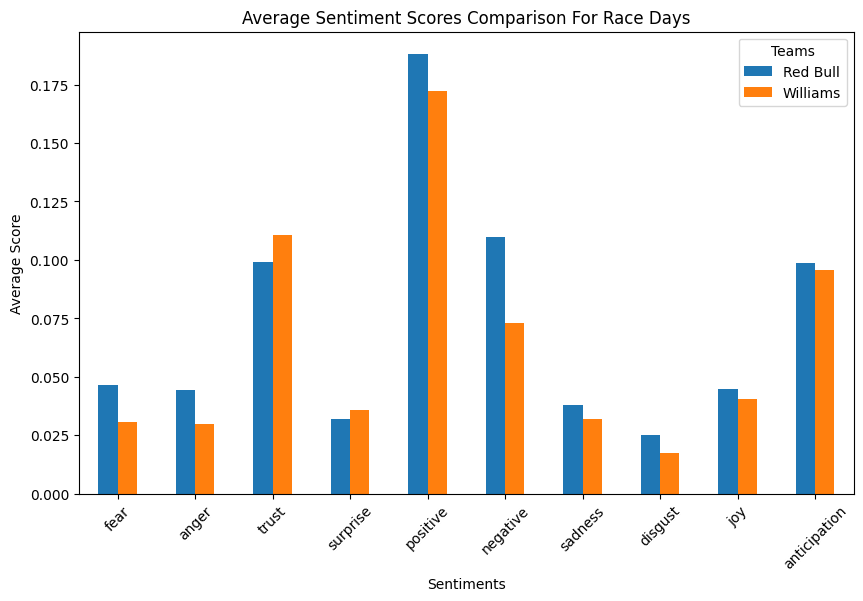

In [82]:
# Function to perform sentiment analysis
def analyze_sentiment(text):
    emotion = NRCLex(text)
    return emotion.affect_frequencies

# Apply sentiment analysis to each tweet
df_races_redbull['sentiment'] = df_races_redbull['clean_tweet'].apply(analyze_sentiment)
df_races_williams['sentiment'] = df_races_williams['clean_tweet'].apply(analyze_sentiment)

# Prepare data for plotting
sentiment_df_redbull_races = pd.DataFrame(list(df_races_redbull['sentiment']))
sentiment_df_redbull_races = sentiment_df_redbull_races.fillna(0)  # Replace NaNs with zeros

sentiment_df_williams_races = pd.DataFrame(list(df_races_williams['sentiment']))
sentiment_df_williams_races = sentiment_df_williams_races.fillna(0)  # Replace NaNs with zeros

sentiment_df_redbull_races.drop('anticip', axis=1, inplace=True)
sentiment_df_williams_races.drop('anticip', axis=1, inplace=True)

# Calculate average sentiment
average_sentiment_redbull_races = sentiment_df_redbull_races.mean()
average_sentiment_williams_races = sentiment_df_williams_races.mean()

# Combine the data for plotting
combined_sentiments_races = pd.DataFrame({
    'Red Bull': average_sentiment_redbull_races,
    'Williams': average_sentiment_williams_races
})

# Plotting
ax = combined_sentiments_races.plot(kind='bar', figsize=(10, 6))
plt.title('Average Sentiment Scores Comparison For Race Days')
plt.xlabel('Sentiments')
plt.ylabel('Average Score')
plt.xticks(rotation=45)
plt.legend(title='Teams')
plt.show()

## Inference for above graph -
The "Average Sentiment Scores Comparison For Race Days" graph shows that Red Bull was favored on Twitter with higher sentiment scores, especially in positive sentiment (above 0.15) and joy on race days of the F1 2021 season. Williams, while eliciting favorable sentiment, trails behind with a positive sentiment score just above 0.1 but leads in anticipation, nearing 0.1.

Negative sentiments like fear, anger, sadness, and disgust register low for both teams, with Williams slightly higher, indicating fewer negative reactions from fans. Red Bull's trust sentiment score, just above 0.05, suggests confidence in their race day performance, while the low surprise scores for both teams suggest outcomes were within expected ranges.

The main conclusion from the graph is that Red Bull enjoyed more positive reception and confidence from their fanbase during race days, while Williams' fans held a hopeful yet guarded optimism, with a little more negativity possibly due to their unpredictability or underdog position.

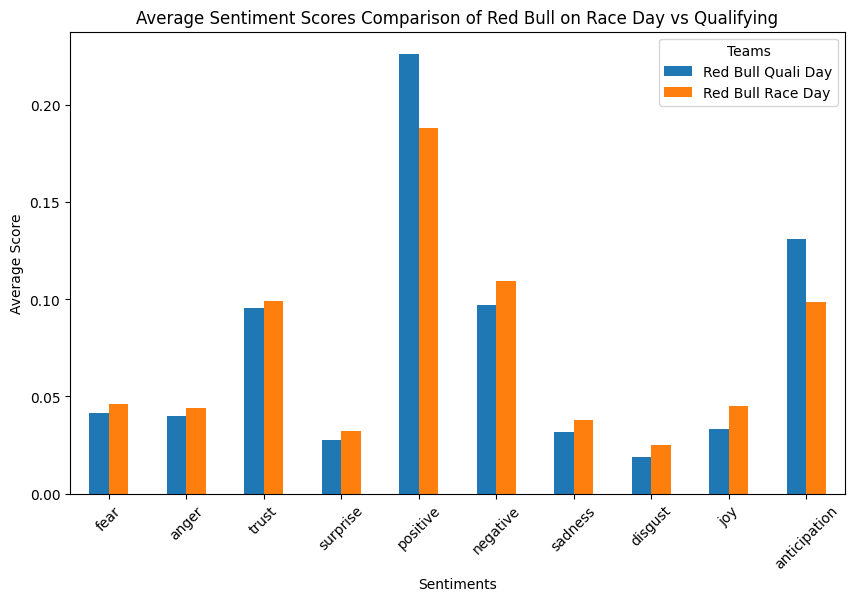

In [83]:
# Combine the data for plotting
combined_sentiments_races_redbull = pd.DataFrame({
    'Red Bull Quali Day': average_sentiment_redbull,
    'Red Bull Race Day': average_sentiment_redbull_races
})

# Plotting
ax = combined_sentiments_races_redbull.plot(kind='bar', figsize=(10, 6))
plt.title('Average Sentiment Scores Comparison of Red Bull on Race Day vs Qualifying')
plt.xlabel('Sentiments')
plt.ylabel('Average Score')
plt.xticks(rotation=45)
plt.legend(title='Teams')
plt.show()

##Inference for above graph -
The sentiment analysis for Red Bull during the 2021 F1 season reveals that the team was met with greater positive sentiment on race days (just under 0.20) than on qualifying days (just above 0.15). Similarly, joy was higher on race days, indicating fans' happier reactions to the actual races compared to the qualifiers. Anticipation was more elevated during qualifying days, suggesting higher expectations ahead of the races. Trust sentiment was slightly stronger on race days, whereas negative sentiments remained low but were a tad higher during qualifying. Overall, the data suggests that Red Bull's race performances resonated more positively with fans, with race days seeing a stronger approval than qualifying days.

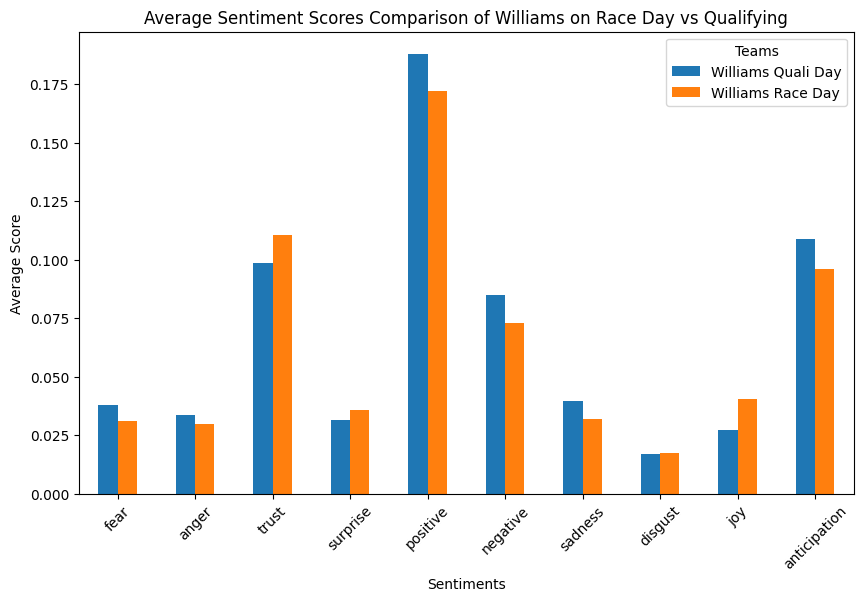

In [84]:
# Combine the data for plotting
combined_sentiments_races_williams = pd.DataFrame({
    'Williams Quali Day': average_sentiment_williams,
    'Williams Race Day': average_sentiment_williams_races
})

# Plotting
ax = combined_sentiments_races_williams.plot(kind='bar', figsize=(10, 6))
plt.title('Average Sentiment Scores Comparison of Williams on Race Day vs Qualifying')
plt.xlabel('Sentiments')
plt.ylabel('Average Score')
plt.xticks(rotation=45)
plt.legend(title='Teams')
plt.show()

## Inference for above graph -
The sentiment comparison for Williams F1 team in 2021 shows higher positive sentiment on race days (around 0.15) than on qualifying days (approximately 0.125), reflecting a more favorable Twitter response to their race performances. Anticipation sentiment peaks on race days (near 0.175), suggesting heightened expectations. Negative sentiments are low overall but slightly higher on race days. Trust is greater during qualifying (just above 0.05), while joy is higher on race days, indicating satisfaction with the outcomes. In essence, Williams garnered a more positive and expectant reaction on race days, despite a small uptick in negative sentiment.

## Question 5 - How did the emotions in F1-related tweets evolve during the 2021 Abu Dhabi Grand Prix, the most watched race in F1 history, with the changing race lead ?

In [125]:
tweets=tweets_uni.copy()
# Convert the date string to a pandas datetime object
tweets['date_time'] = pd.to_datetime(tweets['date'], errors='coerce')

# Drop rows where the datetime conversion resulted in NaT
tweets.dropna(subset=['date_time'], inplace=True)

tweets['date']=tweets['date_time'].dt.date
tweets['time']=tweets['date_time'].dt.time
tweets.drop(['user_created'], axis=1, inplace=True)

In [126]:
tweets['cleaned_tweet']=tweets['text'].apply(clean_tweet)
tweets['text']=tweets['cleaned_tweet']
tweets=tweets.drop(['cleaned_tweet'],axis=1)

In [87]:
abu_dhabi = tweets[tweets['date'] == pd.Timestamp('2021-12-12')]

In [88]:
#Function to analyze emotions
def analyze_emotions(text):
    emotion_scores = NRCLex(text).affect_frequencies
    return emotion_scores

# Round the timestamps to the nearest minute and nearest hour
abu_dhabi['time_minute'] = pd.to_datetime(abu_dhabi['time'], format='%H:%M:%S').dt.floor('T')
abu_dhabi['time_hour'] = pd.to_datetime(abu_dhabi['time'], format='%H:%M:%S').dt.floor('H')

# Step 3: Analyze emotions for each tweet
abu_dhabi['emotions'] = abu_dhabi['text'].apply(analyze_emotions)

In [89]:
# Round the timestamps to the nearest minute and nearest hour
abu_dhabi['time_minute'] = abu_dhabi['time_minute'].dt.time
abu_dhabi['time_hour'] = abu_dhabi['time_hour'].dt.time
abu_dhabi_race_time=abu_dhabi[abu_dhabi['time_hour'].between(pd.Timestamp('12:00:00').time(), pd.Timestamp('16:00:00').time())]

In [90]:
tweets=abu_dhabi_race_time

# Load the spaCy model
nlp = spacy.load("en_core_web_sm")

# Assuming you have a DataFrame named 'tweets' with a column named 'text'
max_redbull_list = ['max', 'verstappen', 'redbull']


# Function to extract keywords from text using spaCy
def extract_keywords(text):
    doc = nlp(text)
    keywords = [token.text.lower() for token in doc if token.text.lower() in max_redbull_list]
    return keywords

# Apply the function to the 'text' column and create a new column 'keywords'
tweets['max_rb_keywords'] = tweets['text'].apply(extract_keywords)

# Filter rows where at least one keyword is present
tweets_with_max_redbull = tweets[tweets['max_rb_keywords'].apply(lambda x: len(x) > 0)]


In [91]:
# Assuming you have a DataFrame named 'tweets' with a column named 'text'
ham_merc_list = ['hamilton', 'ham', 'lewis', 'mercedes',]


# Function to extract keywords from text using spaCy
def extract_keywords(text):
    doc = nlp(text)
    keywords = [token.text.lower() for token in doc if token.text.lower() in ham_merc_list]
    return keywords

# Apply the function to the 'text' column and create a new column 'keywords'
tweets['ham_merc_keywords'] = tweets['text'].apply(extract_keywords)

# Filter rows where at least one keyword is present
tweets_with_ham_merc = tweets[tweets['ham_merc_keywords'].apply(lambda x: len(x) > 0)]


In [92]:
# Plotting for max

df_emotions_max_rb=pd.DataFrame()
for specific_key in tweets_with_max_redbull['emotions'].iloc[0].keys():
# specific_key="positive"
    df=tweets_with_max_redbull
    dictionaries = tweets_with_max_redbull['emotions']
    values = [d.get(specific_key) for d in dictionaries]
    df_emotions_max_rb[specific_key]=values

df_emotions_max_rb['time_minute']=df['time_minute'].reset_index().drop('index',axis=1)

df_sum_emotions_max_rb=df_emotions_max_rb.groupby('time_minute').sum().reset_index()

In [93]:
time_stamps=[['13:35:00', "Max closes up the gap with Hamilton to 2 seconds",50],
 ['14:32:00',"Max Overtakes Hamilton in Last Lap",110]]

emotion_keys = ['positive', 'negative', 'anger', 'surprise']
fig = px.line(df_sum_emotions_max_rb, x=df_sum_emotions_max_rb['time_minute'], y=emotion_keys,
              labels={'index': 'Timestamp', 'value': 'Emotion Intensity'},
              title='Emotion Trends Over Time for Max Verstappen for Abu Dhabi 2021',
              line_dash_sequence=['solid', 'solid', 'solid', 'solid'])

for timestamp,comment,y1 in time_stamps:
    fig.add_shape(
        dict(
            type="line",
            x0=timestamp,
            x1=timestamp,
            y0=0,
            y1=y1,
            line=dict(color="red", width=2, dash="dash")
        )
    )
    fig.add_annotation(
        dict(
            x=timestamp,
            y=y1,  # Adjust the y-coordinate for annotation placement
            text=comment,
            showarrow=True,
            arrowhead=5,
            ax=0,
            ay=-40
        )
    )

fig.update_layout(
    legend=dict(
        title='Emotions',
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ),
    xaxis_title='Timestamp',
    yaxis_title='Emotion Intensity'
)

fig.show()

Inference from the above plot for Max Verstappen (Redbull Driver):
1. At the start of the race at 13:00:00, though Max starts first on the grid but loses his lead in the starting few seconds to Hamilton and hence a rise of negative tweets is observed for him.
2.After a pit stop, at 13:35:00 in Lap 21, while Perez kept on tussling with Hamilton to hold him just behind himself for Verstappen to bridge the gap, the strategy worked out and Max was able to close the gap to 2 seconds emerging as a strong contender for the race win as half of the race still remained leading to a surge in positive sentiment for Max in the tweets from that moment.
3.At the thrilling moment of 14:35:00, in the very last lap 58, Max overtook Hamilton to give his fans a burst of joy and hence the significant rise in positive sentiment in the tweets for Max Verstappen.
However, a lot of F1 fans, especially Hamilton's criticized the selective unlapping of drivers that was done by FIA or Michael Masi, the race director and hence negativity also ensued criticizing Max and Redbull.


In [94]:
# Plotting for Hamilton

df_emotions_ham_merc=pd.DataFrame()
for specific_key in tweets_with_ham_merc['emotions'].iloc[0].keys():
# specific_key="positive"
    df=tweets_with_ham_merc
    dictionaries = tweets_with_ham_merc['emotions']
    values = [d.get(specific_key) for d in dictionaries]
    df_emotions_ham_merc[specific_key]=values

df_emotions_ham_merc['time_minute']=df['time_minute'].reset_index().drop('index',axis=1)

In [95]:
df_sum_emotions_ham_merc=df_emotions_ham_merc.groupby('time_minute').sum().reset_index()

In [96]:
time_stamps=[['13:00:00',"Hamilton was 2nd on grid but takes lead", 33],
             ['13:35:00', "Hamilton takes over from Perez the race lead",45],
              ['14:32:00', "Hamilton is overtaken by Max in Last Lap",50]]

emotion_keys = ['positive', 'negative', 'anger', 'surprise']
fig = px.line(df_sum_emotions_ham_merc, x=df_sum_emotions_ham_merc['time_minute'], y=emotion_keys,
              labels={'index': 'Timestamp', 'value': 'Emotion Intensity'},
              title='Emotion Trends Over Time for Hamilton for Abu Dhabi 2021',
              line_dash_sequence=['solid', 'solid', 'solid', 'solid'])

for timestamp,comment,y_1 in time_stamps:
    fig.add_shape(
        dict(
            type="line",
            x0=timestamp,
            x1=timestamp,
            y0=0,
            y1=y_1,
            line=dict(color="red", width=2, dash="dash")
        )
    )
    fig.add_annotation(
        dict(
            x=timestamp,
            y=y_1,  # Adjust the y-coordinate for annotation placement
            text=comment,
            showarrow=True,
            arrowhead=5,
            ax=0,
            ay=-40
        )
    )

fig.update_layout(
    legend=dict(
        title='Emotions',
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ),
    xaxis_title='Timestamp',
    yaxis_title='Emotion Intensity'
)

fig.show()


Inference for Hamilton Tweet Sentiment over the race:

1. At the start of the race @ 13:00:00, hamilton starts second but takes the lead right at the start of the race and
hence there is a spike in positive tweets for him. However Max gave him a tough fight and at turn 5 of the first lap,
there was a close collision between the two as Hamilton didn't give Max space while Max was overtaking and rather went
off the track to maintain his lead. That was a negative moment for Max and F1 fans, and hence negative tweets also
peaked up.

2. At 13:35:00 in Lap 21, Hamilton overtakes Perez after a lengthy tussle between the two. Hence the nature of the tweets
for Hamilton remained high in both positive and negative.

3. Then Hamilton maintains the closely tailed lead till lap 53 when the Williams Driver, Nicholas Latifi crashes and leads to
safety car being deployed. The safety process went on till lap 58, 14:32:00, when race began again with a controversial
verdict by FIA which led to Max getting an advantage and enabling him to overtake Hamilton on the last lap of the race
and not just winning the race but also the Driver's Championship for the first time.

## Question 6 - What specific words, phrases, or hashtags in Formula 1-related tweets can be linked to positive or negative sentiments, and how do these correlate with particular occurrences in the sport ?

In [107]:
tweets=tweets_uni.copy()

In [108]:
tweets.rename(columns={'date': 'datetime'}, inplace=True)

In [109]:
# Function to extract valid datetime from a string
def extract_datetime(s):
    # Regular expression pattern to match valid datetime format (YYYY-MM-DD HH:MM:SS)
    pattern = r'\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}'
    match = re.search(pattern, s)
    return match.group(0) if match else None

# Applying the function to extract valid datetime
tweets['cleaned_datetime'] = tweets['datetime'].apply(extract_datetime)

In [110]:
tweets['date'] = pd.to_datetime(tweets['cleaned_datetime']).dt.date
tweets['time'] = pd.to_datetime(tweets['cleaned_datetime']).dt.time

In [111]:
tweets['date'] = pd.to_datetime(tweets['date'])
df_saudi = tweets[tweets['date'] == pd.Timestamp('2022-03-27')]

In [112]:
# Define keywords related to the Saudi GP missile attack
keywords = [
    "missile", "attack", "safety", "security", "cancel", "cancellation",
    "yemen", "houthi", "alert", "evacuation", "emergency",
    "reaction", "response","terrorists","oil", "conflict"
]

# Filter tweets containing any of the keywords
pattern = '|'.join(keywords)
df_filtered = df_saudi[df_saudi['text'].str.contains(pattern, case=False, na=False)]

In [113]:
# Clean the tweets
df_filtered['clean_tweet'] = df_filtered['text'].apply(clean_tweet)

In [114]:
# Initialize the pipeline for sentiment analysis
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
sentiment_pipeline = pipeline("sentiment-analysis", model=model_name)

Applying the model on preprocessed tweets -

In [115]:
# Sentiment Analysis using the Twitter-roBERTa-base model
def get_sentiment(tweet):
    result = sentiment_pipeline(tweet)[0]
    return result['label'].lower()

df_filtered['sentiment'] = df_filtered['clean_tweet'].apply(get_sentiment)

# Count the number of each sentiment category
sentiment_counts = df_filtered['sentiment'].value_counts()

### Bar Plot representing the number of tweets having a positive, neutral or negative sentiment which had the above keywords -

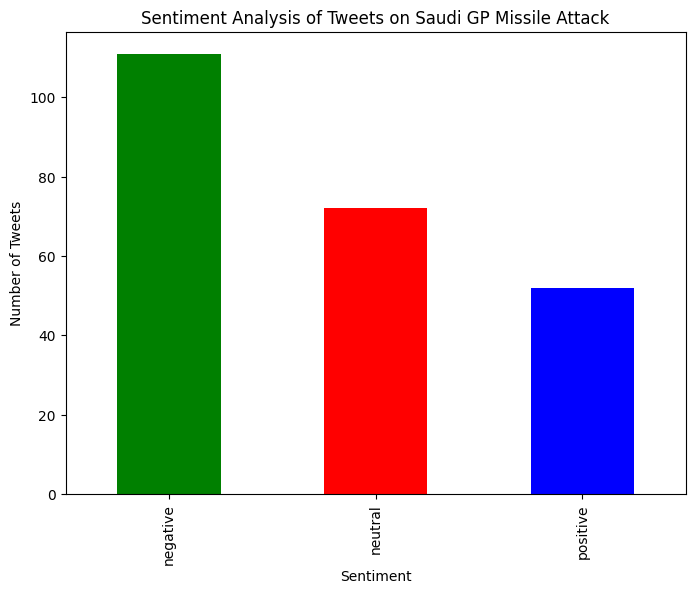

In [116]:
# Plotting sentiment counts
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['green', 'red', 'blue'])
plt.title('Sentiment Analysis of Tweets on Saudi GP Missile Attack')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
# plt.xticks(rotation=0)
plt.xticks(ticks=[0, 1, 2], labels=['negative', 'neutral', 'positive'])
plt.show()

### Inference of the above plot -
The graph shows that negative sentiments dominate, with the highest number of tweets. This reflects the concerns and shock within the Formula 1 community over the security risks posed by such a nearby attack. Neutral sentiment tweets, which may reflect news reporting or factual updates without emotional commentary, are slightly fewer. Positive sentiment tweets are the least, which could indicate expressions of relief or gratitude for the safety of individuals.

Real-life scenarios that occurred during the Saudi attack include the immediate response by the F1 authorities and the drivers' discussions about whether to proceed with the event. Drivers like Lewis Hamilton and Max Verstappen, leading figures in the sport, were likely involved in discussions about the race's continuance.


### Word cloud of the most occuring words from the filtered out tweets -

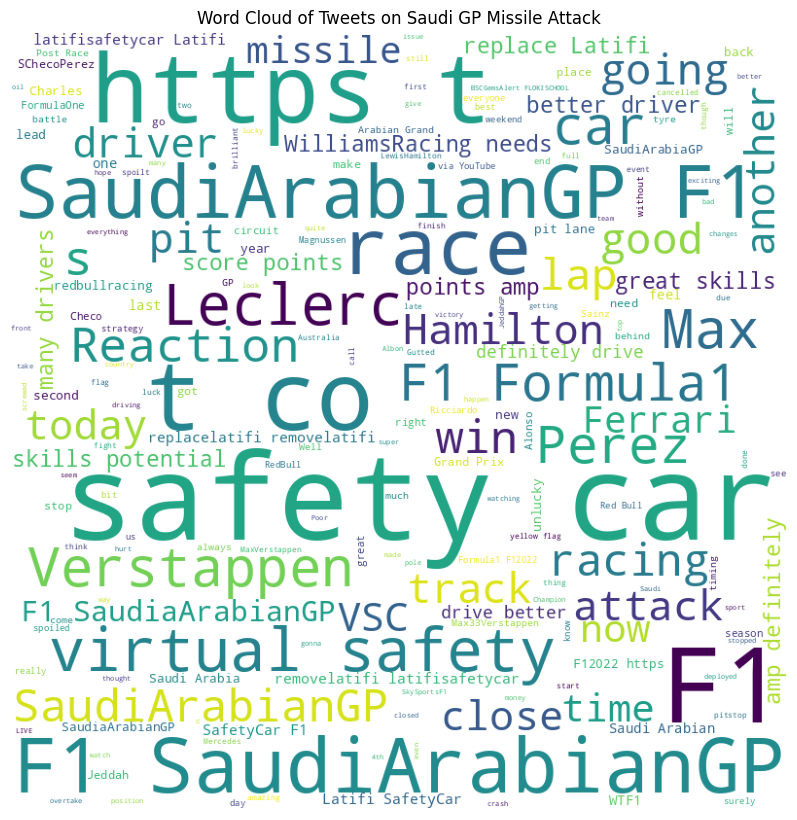

In [117]:
def create_word_cloud(tweets, title):
    text = " ".join(tweet for tweet in tweets)
    word_cloud = WordCloud(width=800, height=800, background_color='white').generate(text)
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(word_cloud)
    plt.title(title)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

create_word_cloud(df_filtered['text'], "Word Cloud of Tweets on Saudi GP Missile Attack")

### Analyzing the distribution of tweet lengths can provide insights into the nature of the discourse (e.g., whether it tends toward longer explanations or shorter reactions) -

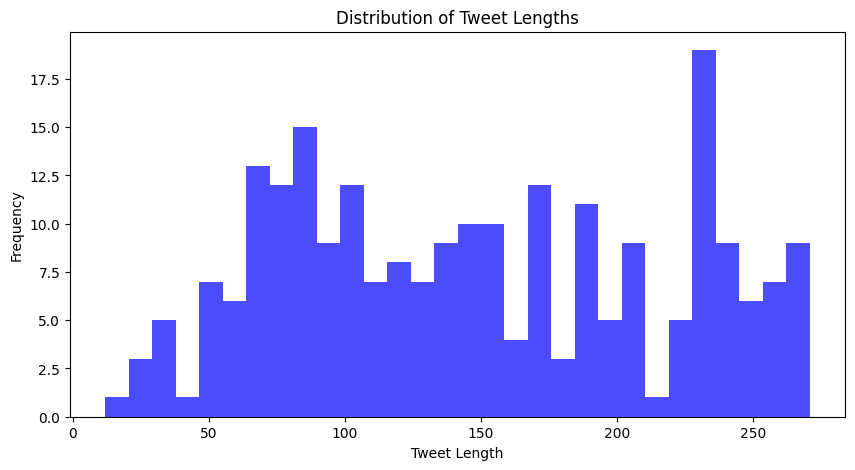

In [118]:
# Calculate tweet lengths
df_filtered['tweet_length'] = df_filtered['clean_tweet'].apply(len)

# Plotting
plt.figure(figsize=(10, 5))
plt.hist(df_filtered['tweet_length'], bins=30, color='blue', alpha=0.7)
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.show()

### Frequency of Key Terms by Hour -
(Analyze how often certain keywords were mentioned in tweets throughout the day)

In [119]:
df_saudi['hour'] = df_saudi['time'].apply(lambda x: x.hour)

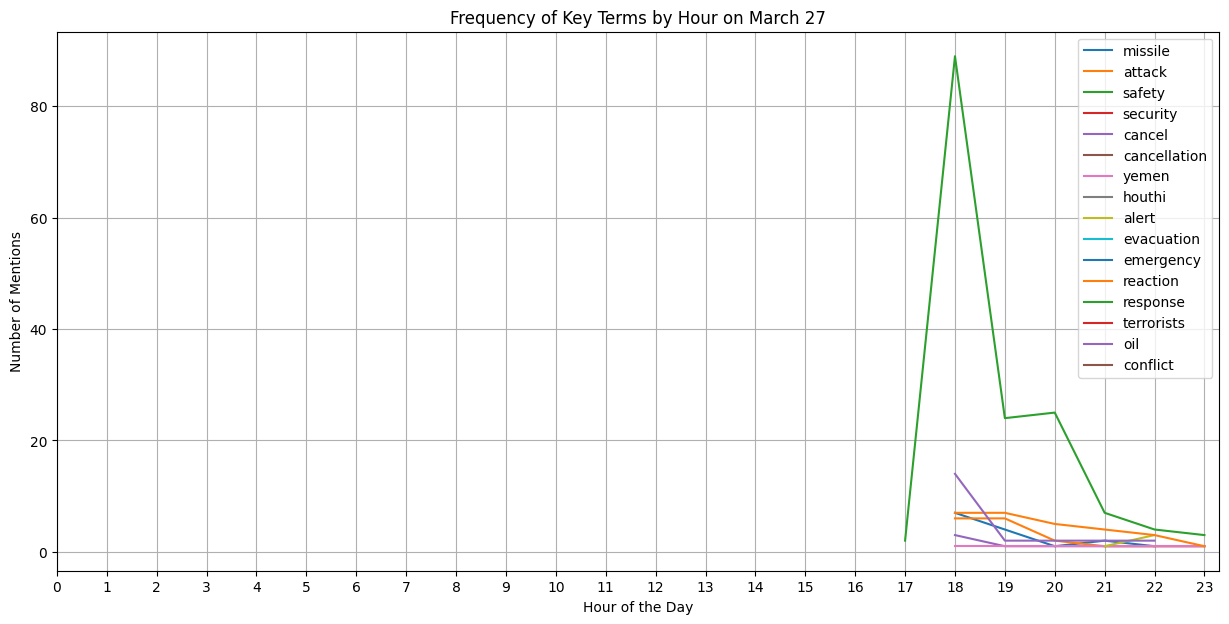

In [120]:
# Plotting
plt.figure(figsize=(15, 7))

for keyword in keywords:
    # Filter tweets containing the keyword and count occurrences by hour
    keyword_counts = df_saudi[df_saudi['text'].str.contains(keyword, case=False, na=False)].groupby('hour').size()
    plt.plot(keyword_counts, label=keyword)

plt.title('Frequency of Key Terms by Hour on March 27')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Mentions')
plt.legend()
plt.xticks(range(24))
plt.grid(True)
plt.show()

# END OF NOTEBOOK | THANK YOU !!!